In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch


In [17]:
df = pd.read_csv('emnist-balanced-train.csv', header=None)

df.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,45,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,36,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,43,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
df.shape

(112800, 785)

In [19]:
mapping = pd.read_csv('emnist-balanced-mapping.txt', delimiter=' ', header=None)

mapping_dict = {mapping.iloc[i, 0]: chr(mapping.iloc[i, 1]) for i in range(len(mapping))}

mapping_dict

{0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9',
 10: 'A',
 11: 'B',
 12: 'C',
 13: 'D',
 14: 'E',
 15: 'F',
 16: 'G',
 17: 'H',
 18: 'I',
 19: 'J',
 20: 'K',
 21: 'L',
 22: 'M',
 23: 'N',
 24: 'O',
 25: 'P',
 26: 'Q',
 27: 'R',
 28: 'S',
 29: 'T',
 30: 'U',
 31: 'V',
 32: 'W',
 33: 'X',
 34: 'Y',
 35: 'Z',
 36: 'a',
 37: 'b',
 38: 'd',
 39: 'e',
 40: 'f',
 41: 'g',
 42: 'h',
 43: 'n',
 44: 'q',
 45: 'r',
 46: 't'}

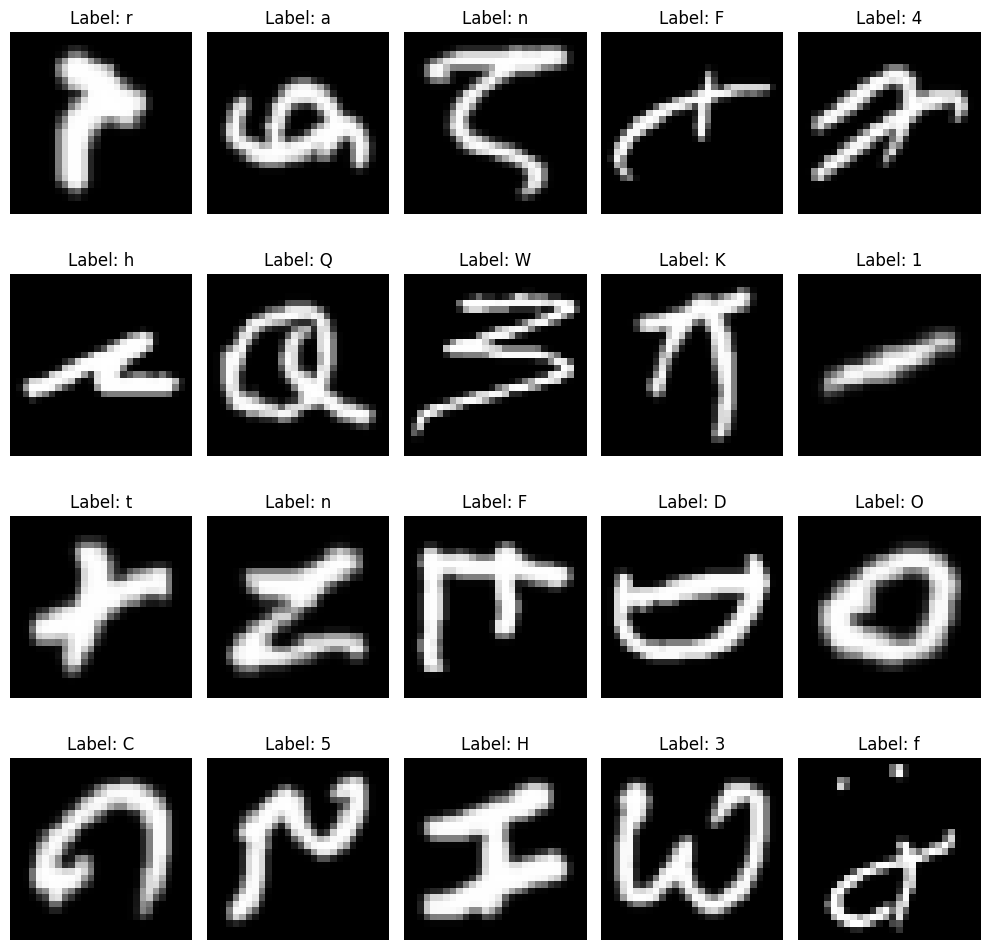

In [20]:
fig, axes = plt.subplots(4, 5, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    example = df.iloc[i, ]
    label = mapping_dict[example.iloc[0]]
    
    example = example[1:].values.reshape(28, 28)
    
    ax.imshow(example, cmap='gray')
    ax.set_title(f'Label: {label}')
    ax.axis('off')

plt.tight_layout()
plt.show()

Są odwrócone domyślnie, więc przekręcam je poziomo, a następnie o 90 stopni w kierunku przeciwnym do kierunku ruchu wskazówek zegara (odwrót ukośny).

In [21]:
for i in range(df.shape[0]):
    pixels = df.iloc[i,1:]
    
    image = pixels.values.reshape(28,28).T #odwrót wg ukosu
    pixels = image.flatten()
    
    df.iloc[i,1:] = pixels

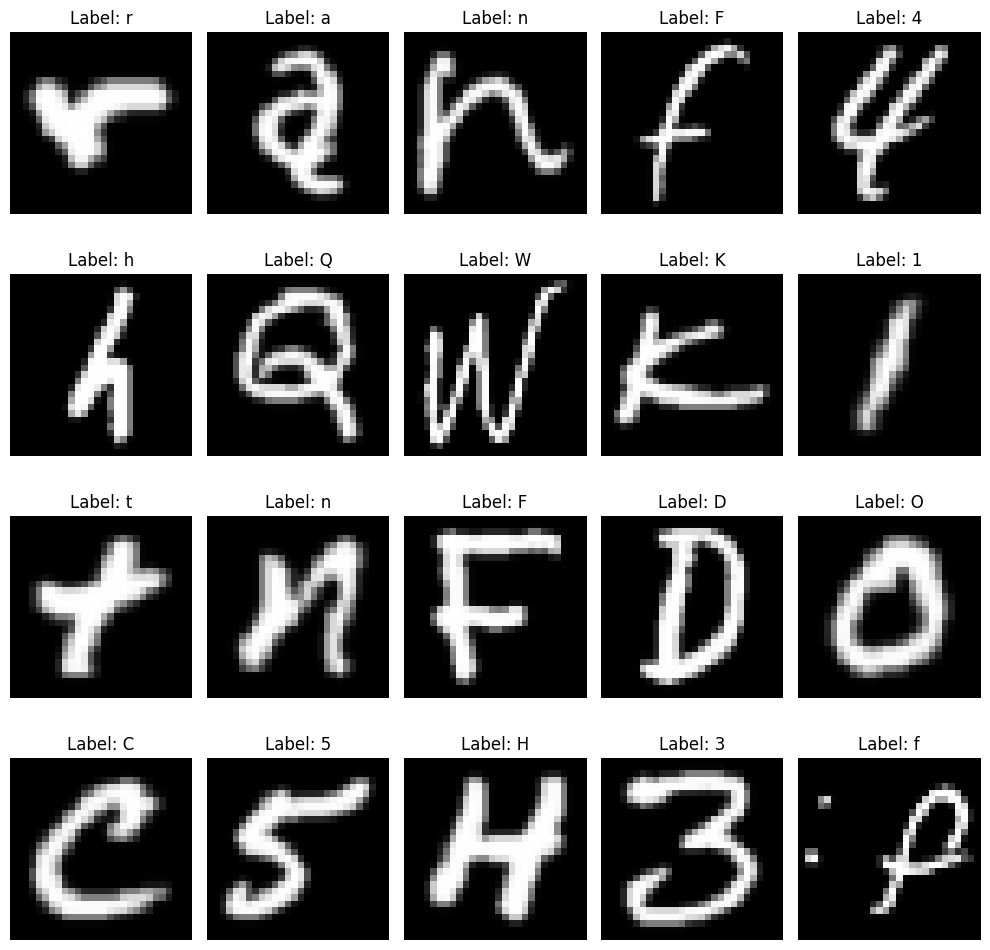

In [22]:
fig, axes = plt.subplots(4, 5, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    example = df.iloc[i, ]
    label = mapping_dict[example.iloc[0]]
    
    example = example[1:].values.reshape(28, 28)
    
    ax.imshow(example, cmap='gray')
    ax.set_title(f'Label: {label}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [23]:
print(df.iloc[:, 1:].max().max())

255


In [24]:
import torch.nn.functional as F
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        
        out += identity
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=47):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


In [30]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.data import random_split

X = df.iloc[:, 1:].values / 255.0
y = df.iloc[:, 0].values

class EMNISTDataset(Dataset):
    def __init__(self, X, y):
        self.X = X.astype('float32')
        self.y = y.astype('int64')
        self.transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
        ])

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx].reshape(28, 28)
        X = self.transform(X)
        y = self.y[idx]
        return X, y
    
    
dataset = EMNISTDataset(X, y)

train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # Remaining 20% for validation

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1024, shuffle=False)

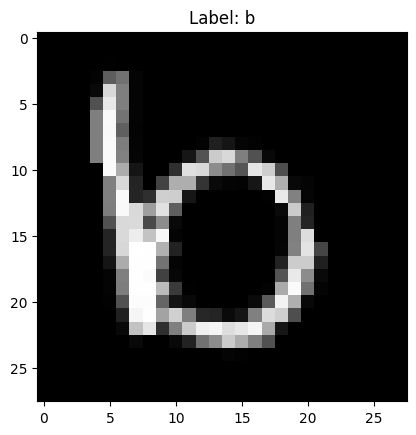

In [38]:
sampleX, sampley = next(iter(val_dataloader))

sampleX.shape, sampley.shape

image = sampleX[0].squeeze().permute(-2, -1)

plt.imshow(image, cmap='gray')
plt.title(f'Label: {mapping_dict[sampley[0].item()]}')
plt.show()

In [13]:
import torch
import torch.optim as optim
from tqdm import tqdm
from torch.amp import GradScaler, autocast
from torch.optim.lr_scheduler import ReduceLROnPlateau

model = ResNet(ResidualBlock, [1, 1, 1, 1], num_classes=47).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
scaler = GradScaler()

c:\Users\jedno\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\amp\grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [14]:
num_epochs = 10

torch.cuda.empty_cache()

for epoch in range(num_epochs):

    # Training Phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    train_progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
    
    for inputs, labels in train_progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        with autocast("cuda"):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)
        
        train_progress_bar.set_postfix(loss=loss.item(), accuracy=100 * train_correct / train_total)
    
    train_epoch_loss = train_loss / len(train_dataloader)
    train_epoch_accuracy = 100 * train_correct / train_total

    # Validation Phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    val_progress_bar = tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False)
    
    with torch.no_grad():
        for inputs, labels in val_progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            with autocast("cuda"):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
            
            val_progress_bar.set_postfix(loss=loss.item(), accuracy=100 * val_correct / val_total)
    
    val_epoch_loss = val_loss / len(val_dataloader)
    val_epoch_accuracy = 100 * val_correct / val_total

    # Print Epoch Summary
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_epoch_loss:.4f}, Train Accuracy: {train_epoch_accuracy:.2f}%, "
          f"Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {val_epoch_accuracy:.2f}%")
    
    # Step the scheduler with validation loss
    scheduler.step(val_epoch_loss)

print("Finished Training")


Epoch 1/10 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]c:\Users\jedno\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 1/10, Train Loss: 0.8156, Train Accuracy: 74.65%, Val Loss: 0.5626, Val Accuracy: 80.53%


Epoch 2/10, Train Loss: 0.4392, Train Accuracy: 84.46%, Val Loss: 0.4320, Val Accuracy: 84.20%


Epoch 3/10, Train Loss: 0.3925, Train Accuracy: 85.70%, Val Loss: 0.3941, Val Accuracy: 86.01%


Epoch 4/10, Train Loss: 0.3673, Train Accuracy: 86.42%, Val Loss: 0.3818, Val Accuracy: 86.21%


Epoch 5/10, Train Loss: 0.3494, Train Accuracy: 87.10%, Val Loss: 0.4180, Val Accuracy: 85.06%


Epoch 6/10, Train Loss: 0.3444, Train Accuracy: 87.18%, Val Loss: 0.3700, Val Accuracy: 86.81%


Epoch 7/10, Train Loss: 0.3298, Train Accuracy: 87.63%, Val Loss: 0.3475, Val Accuracy: 86.87%


Epoch 8/10, Train Loss: 0.3134, Train Accuracy: 88.11%, Val Loss: 0.3443, Val Accuracy: 87.50%


Epoch 9/10, Train Loss: 0.3146, Train Accuracy: 87.96%, Val Loss: 0.3632, Val Accuracy: 86.68%


Epoch 10/10, Train Loss: 0.3034, Train Accuracy: 88.39%, Val Loss: 0.3305, Val Accuracy: 87.68%
Finished Training


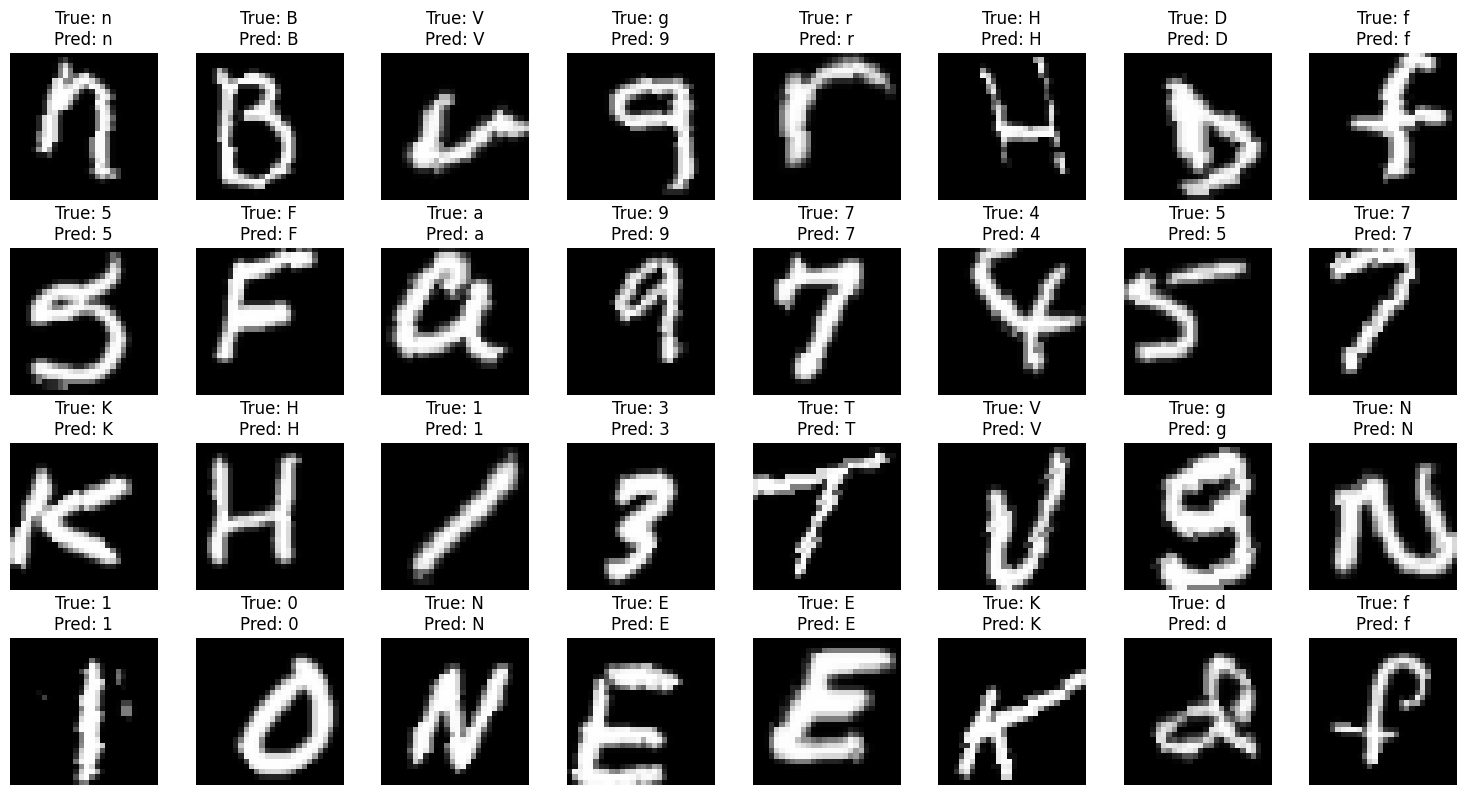

In [17]:

# Set the model to evaluation mode
model.eval()

# Get a batch of data from the dataloader
inputs, labels = next(iter(val_dataloader))

# Move the inputs and labels to the device
inputs, labels = inputs.to(device), labels.to(device)

# Perform the forward pass to get predictions
outputs = model(inputs)

# Get the predicted class
_, preds = torch.max(outputs, 1)

# Plot the images along with the true and predicted labels
fig, axes = plt.subplots(4, 8, figsize=(15, 8))
for i, ax in enumerate(axes.flat):
    img = inputs[i].cpu().numpy().squeeze()
    true_label = mapping_dict[labels[i].item()]
    pred_label = mapping_dict[preds[i].item()]
    
    ax.imshow(img, cmap='gray')
    ax.set_title(f'True: {true_label}\nPred: {pred_label}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [18]:
torch.save(model.state_dict(), 'rn_model.pth')